In [ ]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt

from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor, BaseDRRegressor
from causalml.inference.tree import CausalRandomForestRegressor
from causalml.metrics import get_cumgain, auuc_score, plot_gain
from causalml.dataset import synthetic_data

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.utils.extmath import cartesian
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.base import clone

import seaborn as sns
sns.set_style('whitegrid')
palette = ['plum', 'g', 'orange', 'r', 'b', 'yellow', 'cyan', 'white']

import xgboost as xgb
from xgboost import XGBRegressor

from itertools import product

Failed to import duecredit due to No module named 'duecredit'


In [7]:
from copy import deepcopy
import logging
from tqdm import tqdm
from scipy.stats import norm, uniform
from scipy.spatial import cKDTree
from scipy.spatial.distance import cdist
from scipy.special import softmax as scipy_softmax

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from causalml.inference.meta.base import BaseLearner
from causalml.inference.meta.utils import (
    check_treatment_vector,
    check_p_conditions,
    convert_pd_to_np,
)
from causalml.metrics import regression_metrics
from causalml.propensity import compute_propensity_score

logger = logging.getLogger("causalml")

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [9]:
class BaseRTLearner(BaseLearner):
    """A parent class for H-learner regressor classes.

    A H-learner estimates treatment effects with three machine learning models."""

    def __init__(
        self,
        learner=None,
        outcome_learner=None,
        control_effect_learner=None,
        treatment_effect_learner=None,
        ate_alpha=0.05,
        control_name=0,
    ):
        """Initialize a H-learner.

        Args:
            learner (optional): a model to estimate outcomes and treatment effects in both the control and treatment
                groups
            outcome_learner (optional): a model to estimate outcomes
            control_effect_learner (optional): a model to estimate treatment effects in the control group
            treatment_effect_learner (optional): a model to estimate treatment effects in the treatment group
            ate_alpha (float, optional): the confidence level alpha of the ATE estimate
            control_name (str or int, optional): name of control group
        """
        assert (learner is not None) or (
            (outcome_learner is not None)
            and (control_effect_learner is not None)
            and (treatment_effect_learner is not None)
        )

        if outcome_learner is None:
            self.model_mu = deepcopy(learner)
        else:
            self.model_mu = outcome_learner

        if control_effect_learner is None:
            self.model_tau_c = deepcopy(learner)
        else:
            self.model_tau_c = control_effect_learner

        if treatment_effect_learner is None:
            self.model_tau_t = deepcopy(learner)
        else:
            self.model_tau_t = treatment_effect_learner

        self.ate_alpha = ate_alpha
        self.control_name = control_name

        self.propensity = None
        self.propensity_model = None
        self.model_p = LogisticRegression()

    def __repr__(self):
        return (
            "{}(outcome_learner={},\n"
            "\tcontrol_effect_learner={},\n"
            "\ttreatment_effect_learner={})".format(
                self.__class__.__name__,
                self.model_mu.__repr__(),
                self.model_tau_c.__repr__(),
                self.model_tau_t.__repr__(),
            )
        )

    def fit(self, X, treatment, y, p=None):
        """Fit the inference model.

        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series): a treatment vector
            y (np.array or pd.Series): an outcome vector
            p (np.ndarray or pd.Series or dict, optional): an array of propensity scores of float (0,1) in the
                single-treatment case; or, a dictionary of treatment groups that map to propensity vectors of
                float (0,1); if None will run ElasticNetPropensityModel() to generate the propensity scores.
        """
        X, treatment, y = convert_pd_to_np(X, treatment, y)
        check_treatment_vector(treatment, self.control_name)
        self.t_groups = np.unique(treatment[treatment != self.control_name])
        self.t_groups.sort()

        if p is None:
            self._set_propensity_models(X=X, treatment=treatment, y=y)
            p = self.propensity
        else:
            p = self._format_p(p, self.t_groups)

        self._classes = {group: i for i, group in enumerate(self.t_groups)}
        self.models_tau_c = {
            group: deepcopy(self.model_tau_c) for group in self.t_groups
        }
        self.models_tau_t = {
            group: deepcopy(self.model_tau_t) for group in self.t_groups
        }

        self.vars_c = {}
        self.vars_t = {}

        # Train outcome model
        self.model_mu.fit(X, y)

        for group in self.t_groups:
            mask = (treatment == group) | (treatment == self.control_name)
            treatment_filt = treatment[mask]
            X_filt = X[mask]
            y_filt = y[mask]
            w = (treatment_filt == group).astype(int)

            # Calculate variances and treatment effects
            var_c = (
                y_filt[w == 0] - self.model_mu.predict(X_filt[w == 0])
            ).var()
            self.vars_c[group] = var_c
            var_t = (
                y_filt[w == 1] - self.model_mu.predict(X_filt[w == 1])
            ).var()
            self.vars_t[group] = var_t

            # Train treatment models
            d_c = (self.model_mu.predict(X_filt[w == 0]) - y_filt[w == 0])
            d_t = (y_filt[w == 1] - self.model_mu.predict(X_filt[w == 1]))
            self.models_tau_c[group].fit(X_filt[w == 0], d_c)
            self.models_tau_t[group].fit(X_filt[w == 1], d_t)

    def predict(
        self, X, treatment=None, y=None, p=None, return_components=False, verbose=True
    ):
        """Predict treatment effects.

        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series, optional): a treatment vector
            y (np.array or pd.Series, optional): an outcome vector
            p (np.ndarray or pd.Series or dict, optional): an array of propensity scores of float (0,1) in the
                single-treatment case; or, a dictionary of treatment groups that map to propensity vectors of
                float (0,1); if None will run ElasticNetPropensityModel() to generate the propensity scores.
            return_components (bool, optional): whether to return differences for treatment and control seperately
            verbose (bool, optional): whether to output progress logs
        Returns:
            (numpy.ndarray): Predictions of treatment effects.
        """
        X, treatment, y = convert_pd_to_np(X, treatment, y)

        if p is None:
            logger.info("Generating propensity score")
            p = dict()
            for group in self.t_groups:
                p_model = self.propensity_model[group]
                p[group] = p_model.predict(X)
        else:
            p = self._format_p(p, self.t_groups)

        te = np.zeros((X.shape[0], self.t_groups.shape[0]))
        dhat_cs = {}
        dhat_ts = {}

        for i, group in enumerate(self.t_groups):
            model_tau_c = self.models_tau_c[group]
            model_tau_t = self.models_tau_t[group]
            dhat_cs[group] = model_tau_c.predict(X)
            dhat_ts[group] = model_tau_t.predict(X)

            _te = (dhat_cs[group] + dhat_ts[group]).reshape(
                -1, 1
            )
            te[:, i] = np.ravel(_te)

            if (y is not None) and (treatment is not None) and verbose:
                mask = (treatment == group) | (treatment == self.control_name)
                treatment_filt = treatment[mask]
                X_filt = X[mask]
                y_filt = y[mask]
                w = (treatment_filt == group).astype(int)

                yhat = np.zeros_like(y, dtype=float)
                yhat = self.model_mu.predict(X)

                logger.info("Error metrics for group {}".format(group))
                regression_metrics(y, yhat, w)

        if not return_components:
            return te
        else:
            return te, dhat_cs, dhat_ts

    def fit_predict(
        self,
        X,
        treatment,
        y,
        p=None,
        return_ci=False,
        n_bootstraps=1000,
        bootstrap_size=10000,
        return_components=False,
        verbose=True,
    ):
        """Fit the treatment effect and outcome models of the R learner and predict treatment effects.

        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series): a treatment vector
            y (np.array or pd.Series): an outcome vector
            p (np.ndarray or pd.Series or dict, optional): an array of propensity scores of float (0,1) in the
                single-treatment case; or, a dictionary of treatment groups that map to propensity vectors of
                float (0,1); if None will run ElasticNetPropensityModel() to generate the propensity scores.
            return_ci (bool): whether to return confidence intervals
            n_bootstraps (int): number of bootstrap iterations
            bootstrap_size (int): number of samples per bootstrap
            return_components (bool, optional): whether to return outcome for treatment and control seperately
            verbose (str): whether to output progress logs
        Returns:
            (numpy.ndarray): Predictions of treatment effects. Output dim: [n_samples, n_treatment]
                If return_ci, returns CATE [n_samples, n_treatment], LB [n_samples, n_treatment],
                UB [n_samples, n_treatment]
        """
        X, treatment, y = convert_pd_to_np(X, treatment, y)
        self.fit(X, treatment, y, p)

        if p is None:
            p = self.propensity
        else:
            p = self._format_p(p, self.t_groups)

        te = self.predict(
            X, treatment=treatment, y=y, p=p, return_components=return_components
        )

        if not return_ci:
            return te
        else:
            t_groups_global = self.t_groups
            _classes_global = self._classes
            model_mu_global = deepcopy(self.model_mu)
            models_tau_c_global = deepcopy(self.models_tau_c)
            models_tau_t_global = deepcopy(self.models_tau_t)
            te_bootstraps = np.zeros(
                shape=(X.shape[0], self.t_groups.shape[0], n_bootstraps)
            )

            logger.info("Bootstrap Confidence Intervals")
            for i in tqdm(range(n_bootstraps)):
                te_b = self.bootstrap(X, treatment, y, p, size=bootstrap_size)
                te_bootstraps[:, :, i] = te_b

            te_lower = np.percentile(te_bootstraps, (self.ate_alpha / 2) * 100, axis=2)
            te_upper = np.percentile(
                te_bootstraps, (1 - self.ate_alpha / 2) * 100, axis=2
            )

            # set member variables back to global (currently last bootstrapped outcome)
            self.t_groups = t_groups_global
            self._classes = _classes_global
            self.model_mu = deepcopy(model_mu_global)
            self.models_tau_c = deepcopy(models_tau_c_global)
            self.models_tau_t = deepcopy(models_tau_t_global)

            return (te, te_lower, te_upper)

    def estimate_ate(
        self,
        X,
        treatment,
        y,
        p=None,
        bootstrap_ci=False,
        n_bootstraps=1000,
        bootstrap_size=10000,
        pretrain=False,
    ):
        """Estimate the Average Treatment Effect (ATE).

        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series): a treatment vector
            y (np.array or pd.Series): an outcome vector
            p (np.ndarray or pd.Series or dict, optional): an array of propensity scores of float (0,1) in the
                single-treatment case; or, a dictionary of treatment groups that map to propensity vectors of
                float (0,1); if None will run ElasticNetPropensityModel() to generate the propensity scores.
            bootstrap_ci (bool): whether run bootstrap for confidence intervals
            n_bootstraps (int): number of bootstrap iterations
            bootstrap_size (int): number of samples per bootstrap
            pretrain (bool): whether a model has been fit, default False.
        Returns:
            The mean and confidence interval (LB, UB) of the ATE estimate.
        """
        if pretrain:
            if p is None:
                # when p is null, use pretrain propensity score
                if not self.propensity:
                    raise ValueError("no propensity score, please call fit() first")
                te, dhat_cs, dhat_ts = self.predict(
                    X, treatment, y, p=self.propensity, return_components=True
                )
            else:
                p = self._format_p(p, self.t_groups)
                te, dhat_cs, dhat_ts = self.predict(
                    X, treatment, y, p=p, return_components=True
                )
        else:
            te, dhat_cs, dhat_ts = self.fit_predict(
                X, treatment, y, p, return_components=True
            )
        X, treatment, y = convert_pd_to_np(X, treatment, y)

        if p is None:
            p = self.propensity
        else:
            p = self._format_p(p, self.t_groups)

        ate = np.zeros(self.t_groups.shape[0])
        ate_lb = np.zeros(self.t_groups.shape[0])
        ate_ub = np.zeros(self.t_groups.shape[0])

        for i, group in enumerate(self.t_groups):
            _ate = te[:, i].mean()

            mask = (treatment == group) | (treatment == self.control_name)
            treatment_filt = treatment[mask]
            w = (treatment_filt == group).astype(int)
            prob_treatment = float(sum(w)) / w.shape[0]

            dhat_c = dhat_cs[group][mask]
            dhat_t = dhat_ts[group][mask]
            p_filt = p[group][mask]

            # SE formula is based on the lower bound formula (7) from Imbens, Guido W., and Jeffrey M. Wooldridge. 2009.
            # "Recent Developments in the Econometrics of Program Evaluation." Journal of Economic Literature
            se = np.sqrt(
                (
                    self.vars_t[group] / prob_treatment
                    + self.vars_c[group] / (1 - prob_treatment)
                    + (p_filt * dhat_c + (1 - p_filt) * dhat_t).var()
                )
                / w.shape[0]
            )

            _ate_lb = _ate - se * norm.ppf(1 - self.ate_alpha / 2)
            _ate_ub = _ate + se * norm.ppf(1 - self.ate_alpha / 2)

            ate[i] = _ate
            ate_lb[i] = _ate_lb
            ate_ub[i] = _ate_ub

        if not bootstrap_ci:
            return ate, ate_lb, ate_ub
        else:
            t_groups_global = self.t_groups
            _classes_global = self._classes
            model_mu_global = deepcopy(self.model_mu)
            models_tau_c_global = deepcopy(self.models_tau_c)
            models_tau_t_global = deepcopy(self.models_tau_t)

            logger.info("Bootstrap Confidence Intervals for ATE")
            ate_bootstraps = np.zeros(shape=(self.t_groups.shape[0], n_bootstraps))

            for n in tqdm(range(n_bootstraps)):
                cate_b = self.bootstrap(X, treatment, y, p, size=bootstrap_size)
                ate_bootstraps[:, n] = cate_b.mean()

            ate_lower = np.percentile(
                ate_bootstraps, (self.ate_alpha / 2) * 100, axis=1
            )
            ate_upper = np.percentile(
                ate_bootstraps, (1 - self.ate_alpha / 2) * 100, axis=1
            )

            # set member variables back to global (currently last bootstrapped outcome)
            self.t_groups = t_groups_global
            self._classes = _classes_global
            self.model_mu = deepcopy(model_mu_global)
            self.models_tau_c = deepcopy(models_tau_c_global)
            self.models_tau_t = deepcopy(models_tau_t_global)
            return ate, ate_lower, ate_upper

class BaseRTRegressor(BaseRTLearner):
    """
    A parent class for H-learner regressor classes.
    """

    def __init__(
        self,
        learner=None,
        outcome_learner=None,
        control_effect_learner=None,
        treatment_effect_learner=None,
        ate_alpha=0.05,
        control_name=0,
    ):
        """Initialize an X-learner regressor.

        Args:
            learner (optional): a model to estimate outcomes and treatment effects in both the control and treatment
                groups
            outcome_learner (optional): a model to estimate outcomes
            control_effect_learner (optional): a model to estimate treatment effects in the control group
            treatment_effect_learner (optional): a model to estimate treatment effects in the treatment group
            ate_alpha (float, optional): the confidence level alpha of the ATE estimate
            control_name (str or int, optional): name of control group
        """
        super().__init__(
            learner=learner,
            outcome_learner=outcome_learner,
            control_effect_learner=control_effect_learner,
            treatment_effect_learner=treatment_effect_learner,
            ate_alpha=ate_alpha,
            control_name=control_name,
        )

In [8]:
class BasePLearner(BaseLearner):
    """A parent class for P-learner regressor classes.

    A P-learner estimates treatment effects with one machine learning model."""

    def __init__(
        self,
        learner=None,
        ate_alpha=0.05,
        control_name=0,
    ):
        """Initialize a P-learner.

        Args:
            learner (optional): a model to estimate outcomes and treatment effects in both the control and treatment
                groups
            outcome_learner (optional): a model to estimate outcomes
            control_effect_learner (optional): a model to estimate treatment effects in the control group
            treatment_effect_learner (optional): a model to estimate treatment effects in the treatment group
            ate_alpha (float, optional): the confidence level alpha of the ATE estimate
            control_name (str or int, optional): name of control group
        """
        assert (learner is not None)

        self.model_nu = deepcopy(learner)

        self.ate_alpha = ate_alpha
        self.control_name = control_name

        self.propensity = None
        self.propensity_model = None
        self.model_p = LogisticRegression()

    def __repr__(self):
        return (
            "{}(pairwise_learner={})".format(
                self.__class__.__name__,
                self.model_nu.__repr__(),
            )
        )
    
    def pair_data(self, X, treatment, y, num_samples):

        # Split T=0 and T=1
        X0 = X[treatment == 0]
        Y0 = y[treatment == 0]
        X1 = X[treatment == 1]
        Y1 = y[treatment == 1]

        scaler = MinMaxScaler()
        X1_scaled = scaler.fit_transform(X1)
        X0_scaled = scaler.fit_transform(X0)

        # Build KD-tree from Y
        tree = cKDTree(X1_scaled)

        # Query for k nearest neighbours
        distances, indices = tree.query(X0_scaled, k=num_samples)
        # Randomly sample rows from X_treated for each row in X_control
        random_indices = np.random.randint(0, len(X1), (len(X0), num_samples))
        
        # Expand T=0 data to match shape
        X0_expanded = np.repeat(X0, num_samples, axis=0)  # Repeat X0
        Y0_expanded = np.repeat(Y0, num_samples, axis=0)  # Repeat Y0

        # Get corresponding T=1 data (using the random indices)
        X1_sampled = X1[indices.flatten()]
        Y1_sampled = Y1[indices.flatten()]

        # Reshape the sampled X1 and Y1 for the final DataFrame
        X1_sampled = X1_sampled.reshape(-1, X.shape[1])
        Y1_sampled = Y1_sampled.reshape(-1, 1)

        # Combine the matrices (X0 with X1, Y0 with Y1)
        X_combined = np.concatenate([X0_expanded, X1_sampled], axis=1)  # Concatenate feature matrices
        Y_combined = np.column_stack((Y0_expanded, Y1_sampled))  # Concatenate outcome matrices

        # Calculate outcome differences
        nu = Y_combined[:,1] - Y_combined[:,0]

        return X_combined, nu

    def fit(self, X, treatment, y, p, num_samples=3):
        """Fit the inference model.

        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series): a treatment vector
            y (np.array or pd.Series): an outcome vector
            p (np.ndarray or pd.Series or dict, optional): an array of propensity scores of float (0,1) in the
                single-treatment case; or, a dictionary of treatment groups that map to propensity vectors of
                float (0,1); if None will run ElasticNetPropensityModel() to generate the propensity scores.
            num_samples (optional): number of treated samples to pair with each control.
        """
        
        X, y = convert_pd_to_np(X, y)
        X_pair, nu = self.pair_data(X, treatment, y, num_samples)

        self.t_groups = np.unique(treatment[treatment != self.control_name])
        self.t_groups.sort()

        self._classes = {group: i for i, group in enumerate(self.t_groups)}

        self.vars_c = {}
        self.vars_t = {}

        # Train outcome model
        self.model_nu.fit(X_pair, nu)

        # for group in self.t_groups:
        #     mask = (treatment == group) | (treatment == self.control_name)
        #     treatment_filt = treatment[mask]
        #     X_filt = X[mask]
        #     y_filt = y[mask]
        #     w = (treatment_filt == group).astype(int)

        #     # Calculate variances and treatment effects
        #     var_c = (
        #         y_filt[w == 0] - self.model_mu.predict(X_filt[w == 0])
        #     ).var()
        #     self.vars_c[group] = var_c
        #     var_t = (
        #         y_filt[w == 1] - self.model_mu.predict(X_filt[w == 1])
        #     ).var()
        #     self.vars_t[group] = var_t

        #     # Train treatment models
        #     d_c = (self.model_mu.predict(X_filt[w == 0]) - y_filt[w == 0])
        #     d_t = (y_filt[w == 1] - self.model_mu.predict(X_filt[w == 1]))
        #     self.models_tau_c[group].fit(X_filt[w == 0], d_c)
        #     self.models_tau_t[group].fit(X_filt[w == 1], d_t)

    def predict(
        self, X, treatment=None, y=None, p=None, return_components=False, verbose=True
    ):
        """Predict treatment effects.

        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series, optional): a treatment vector
            y (np.array or pd.Series, optional): an outcome vector
            p (np.ndarray or pd.Series or dict, optional): an array of propensity scores of float (0,1) in the
                single-treatment case; or, a dictionary of treatment groups that map to propensity vectors of
                float (0,1); if None will run ElasticNetPropensityModel() to generate the propensity scores.
            return_components (bool, optional): whether to return differences for treatment and control seperately
            verbose (bool, optional): whether to output progress logs
        Returns:
            (numpy.ndarray): Predictions of treatment effects.
        """

        X, treatment, y = convert_pd_to_np(X, treatment, y)
        X = np.concatenate([X, X], axis=1)

        # if p is None:
        #     logger.info("Generating propensity score")
        #     p = dict()
        #     for group in self.t_groups:
        #         p_model = self.propensity_model[group]
        #         p[group] = p_model.predict(X)
        # else:
        #     p = self._format_p(p, self.t_groups)

        te = np.zeros((X.shape[0], self.t_groups.shape[0]))
        dhat_cs = {}
        dhat_ts = {}

        _te = (self.model_nu.predict(X)).reshape(
            -1, 1
        )
        te[:, 0] = np.ravel(_te)

        # for i, group in enumerate(self.t_groups):
        #     model_tau_c = self.models_tau_c[group]
        #     model_tau_t = self.models_tau_t[group]
        #     dhat_cs[group] = model_tau_c.predict(X)
        #     dhat_ts[group] = model_tau_t.predict(X)

        #     _te = (dhat_cs[group] + dhat_ts[group]).reshape(
        #         -1, 1
        #     )
        #     te[:, i] = np.ravel(_te)

        #     if (y is not None) and (treatment is not None) and verbose:
        #         mask = (treatment == group) | (treatment == self.control_name)
        #         treatment_filt = treatment[mask]
        #         X_filt = X[mask]
        #         y_filt = y[mask]
        #         w = (treatment_filt == group).astype(int)

        #         yhat = np.zeros_like(y, dtype=float)
        #         yhat = self.model_mu.predict(X)

        #         logger.info("Error metrics for group {}".format(group))
        #         regression_metrics(y, yhat, w)

        if not return_components:
            return te
        else:
            return te, dhat_cs, dhat_ts

    def fit_predict(
        self,
        X,
        treatment,
        y,
        p=None,
        num_samples=3,
        return_ci=False,
        n_bootstraps=1000,
        bootstrap_size=10000,
        return_components=False,
        verbose=True,
    ):
        """Fit the treatment effect and outcome models of the R learner and predict treatment effects.

        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series): a treatment vector
            y (np.array or pd.Series): an outcome vector
            p (np.ndarray or pd.Series or dict, optional): an array of propensity scores of float (0,1) in the
                single-treatment case; or, a dictionary of treatment groups that map to propensity vectors of
                float (0,1); if None will run ElasticNetPropensityModel() to generate the propensity scores.
            return_ci (bool): whether to return confidence intervals
            n_bootstraps (int): number of bootstrap iterations
            bootstrap_size (int): number of samples per bootstrap
            return_components (bool, optional): whether to return outcome for treatment and control seperately
            verbose (str): whether to output progress logs
        Returns:
            (numpy.ndarray): Predictions of treatment effects. Output dim: [n_samples, n_treatment]
                If return_ci, returns CATE [n_samples, n_treatment], LB [n_samples, n_treatment],
                UB [n_samples, n_treatment]
        """
        X, treatment, y = convert_pd_to_np(X, treatment, y)
        self.fit(X, treatment, y, p, num_samples)

        if p is None:
            p = self.propensity
        else:
            p = self._format_p(p, self.t_groups)

        te = self.predict(
            X, treatment=treatment, y=y, p=p, return_components=return_components
        )

        if not return_ci:
            return te
        else:
            t_groups_global = self.t_groups
            _classes_global = self._classes
            model_nu_global = deepcopy(self.model_nu)
            te_bootstraps = np.zeros(
                shape=(X.shape[0], self.t_groups.shape[0], n_bootstraps)
            )

            logger.info("Bootstrap Confidence Intervals")
            for i in tqdm(range(n_bootstraps)):
                te_b = self.bootstrap(X, treatment, y, p, size=bootstrap_size)
                te_bootstraps[:, :, i] = te_b

            te_lower = np.percentile(te_bootstraps, (self.ate_alpha / 2) * 100, axis=2)
            te_upper = np.percentile(
                te_bootstraps, (1 - self.ate_alpha / 2) * 100, axis=2
            )

            # set member variables back to global (currently last bootstrapped outcome)
            self.t_groups = t_groups_global
            self._classes = _classes_global
            self.model_nu = deepcopy(model_nu_global)

            return (te, te_lower, te_upper)

    def estimate_ate(
        self,
        X,
        treatment,
        y,
        p=None,
        bootstrap_ci=False,
        n_bootstraps=1000,
        bootstrap_size=10000,
        pretrain=False,
    ):
        """Estimate the Average Treatment Effect (ATE).

        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series): a treatment vector
            y (np.array or pd.Series): an outcome vector
            p (np.ndarray or pd.Series or dict, optional): an array of propensity scores of float (0,1) in the
                single-treatment case; or, a dictionary of treatment groups that map to propensity vectors of
                float (0,1); if None will run ElasticNetPropensityModel() to generate the propensity scores.
            bootstrap_ci (bool): whether run bootstrap for confidence intervals
            n_bootstraps (int): number of bootstrap iterations
            bootstrap_size (int): number of samples per bootstrap
            pretrain (bool): whether a model has been fit, default False.
        Returns:
            The mean and confidence interval (LB, UB) of the ATE estimate.
        """
        if pretrain:
            if p is None:
                # when p is null, use pretrain propensity score
                if not self.propensity:
                    raise ValueError("no propensity score, please call fit() first")
                te, dhat_cs, dhat_ts = self.predict(
                    X, treatment, y, p=self.propensity, return_components=True
                )
            else:
                p = self._format_p(p, self.t_groups)
                te, dhat_cs, dhat_ts = self.predict(
                    X, treatment, y, p=p, return_components=True
                )
        else:
            te, dhat_cs, dhat_ts = self.fit_predict(
                X, treatment, y, p, return_components=True
            )
        X, treatment, y = convert_pd_to_np(X, treatment, y)

        if p is None:
            p = self.propensity
        else:
            p = self._format_p(p, self.t_groups)

        ate = np.zeros(self.t_groups.shape[0])
        ate_lb = np.zeros(self.t_groups.shape[0])
        ate_ub = np.zeros(self.t_groups.shape[0])

        ate[0] = te[:, 0].mean()

        # for i, group in enumerate(self.t_groups):
        #     _ate = te[:, i].mean()

        #     mask = (treatment == group) | (treatment == self.control_name)
        #     treatment_filt = treatment[mask]
        #     w = (treatment_filt == group).astype(int)
        #     prob_treatment = float(sum(w)) / w.shape[0]

        #     dhat_c = dhat_cs[group][mask]
        #     dhat_t = dhat_ts[group][mask]
        #     p_filt = p[group][mask]

        #     # SE formula is based on the lower bound formula (7) from Imbens, Guido W., and Jeffrey M. Wooldridge. 2009.
        #     # "Recent Developments in the Econometrics of Program Evaluation." Journal of Economic Literature
        #     se = np.sqrt(
        #         (
        #             self.vars_t[group] / prob_treatment
        #             + self.vars_c[group] / (1 - prob_treatment)
        #             + (p_filt * dhat_c + (1 - p_filt) * dhat_t).var()
        #         )
        #         / w.shape[0]
        #     )

        #     _ate_lb = _ate - se * norm.ppf(1 - self.ate_alpha / 2)
        #     _ate_ub = _ate + se * norm.ppf(1 - self.ate_alpha / 2)

        #     ate[i] = _ate
        #     ate_lb[i] = _ate_lb
        #     ate_ub[i] = _ate_ub

        if not bootstrap_ci:
            return ate, ate_lb, ate_ub
        else:
            t_groups_global = self.t_groups
            _classes_global = self._classes
            model_nu_global = deepcopy(self.model_nu)

            logger.info("Bootstrap Confidence Intervals for ATE")
            ate_bootstraps = np.zeros(shape=(self.t_groups.shape[0], n_bootstraps))

            for n in tqdm(range(n_bootstraps)):
                cate_b = self.bootstrap(X, treatment, y, p, size=bootstrap_size)
                ate_bootstraps[:, n] = cate_b.mean()

            ate_lower = np.percentile(
                ate_bootstraps, (self.ate_alpha / 2) * 100, axis=1
            )
            ate_upper = np.percentile(
                ate_bootstraps, (1 - self.ate_alpha / 2) * 100, axis=1
            )

            # set member variables back to global (currently last bootstrapped outcome)
            self.t_groups = t_groups_global
            self._classes = _classes_global
            self.model_nu = deepcopy(model_nu_global)
            return ate, ate_lower, ate_upper

class BasePRegressor(BasePLearner):
    """
    A parent class for P-learner regressor classes.
    """

    def __init__(
        self,
        learner=None,
        ate_alpha=0.05,
        control_name=0,
    ):
        """Initialize a P-learner regressor.

        Args:
            learner (optional): a model to estimate outcomes and treatment effects in both the control and treatment
                groups
            ate_alpha (float, optional): the confidence level alpha of the ATE estimate
            control_name (str or int, optional): name of control group
        """
        super().__init__(
            learner=learner,
            ate_alpha=ate_alpha,
            control_name=control_name,
        )

In [10]:
class BaseRPLearner(BaseLearner):
    """A parent class for PH-learner regressor classes.

    A PH-learner estimates treatment effects with two machine learning models."""

    def __init__(
        self,
        learner=None,
        outcome_learner=None,
        pair_learner=None,
        ate_alpha=0.05,
        control_name=0,
    ):
        """Initialize a H-learner.

        Args:
            learner (optional): a model to estimate outcomes and treatment effects in both the control and treatment
                groups
            outcome_learner (optional): a model to estimate outcomes
            pair_learner (optional): a model to estimate pair outcome differences
            treatment_effect_learner (optional): a model to estimate treatment effects in the treatment group
            ate_alpha (float, optional): the confidence level alpha of the ATE estimate
            control_name (str or int, optional): name of control group
        """
        assert (learner is not None) or (
            (outcome_learner is not None)
            and (pair_learner is not None)
        )

        if outcome_learner is None:
            self.model_mu = deepcopy(learner)
        else:
            self.model_mu = outcome_learner

        if pair_learner is None:
            self.model_nu = deepcopy(learner)
        else:
            self.model_nu = pair_learner

        self.ate_alpha = ate_alpha
        self.control_name = control_name

        self.propensity = None
        self.propensity_model = None
        self.model_p = LogisticRegression()

    def __repr__(self):
        return (
            "{}(outcome_learner={},\n"
            "\tpair_learner={})".format(
                self.__class__.__name__,
                self.model_mu.__repr__(),
                self.model_nu.__repr__()
            )
        )
    
    def pair_data(self, X, treatment, y, num_samples):

        # Split T=0 and T=1
        X0 = X[treatment == 0]
        Y0 = y[treatment == 0]
        X1 = X[treatment == 1]
        Y1 = y[treatment == 1]

        scaler = MinMaxScaler()
        X1_scaled = scaler.fit_transform(X1)
        X0_scaled = scaler.fit_transform(X0)

        # Build KD-tree from Y
        tree = cKDTree(X1_scaled)

        # Query for k nearest neighbours
        distances, indices = tree.query(X0_scaled, k=num_samples)
        # Randomly sample rows from X_treated for each row in X_control
        random_indices = np.random.randint(0, len(X1), (len(X0), num_samples))

        # Expand T=0 data to match shape
        X0_expanded = np.repeat(X0, num_samples, axis=0)  # Repeat X0 for 5 times
        Y0_expanded = np.repeat(Y0, num_samples, axis=0)  # Repeat Y0 for 5 times

        # Get corresponding T=1 data (using the random indices)
        X1_sampled = X1[indices.flatten()]
        Y1_sampled = Y1[indices.flatten()]

        # Reshape the sampled X1 and Y1 for the final DataFrame
        X1_sampled = X1_sampled.reshape(-1, X.shape[1])
        Y1_sampled = Y1_sampled.reshape(-1, 1)

        # Combine the matrices (X0 with X1, Y0 with Y1)
        X_combined = np.concatenate([X0_expanded, X1_sampled], axis=1)  # Concatenate feature matrices
        Y_combined = np.column_stack((Y0_expanded, Y1_sampled))  # Concatenate outcome matrices

        # Calculate outcome differences
        nu = Y_combined[:,1] - self.model_mu.predict(X1_sampled) + self.model_mu.predict(X0_expanded) - Y_combined[:,0]

        return X_combined, nu

    def fit(self, X, treatment, y, p=None, num_samples=5):
        """Fit the inference model.

        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series): a treatment vector
            y (np.array or pd.Series): an outcome vector
            p (np.ndarray or pd.Series or dict, optional): an array of propensity scores of float (0,1) in the
                single-treatment case; or, a dictionary of treatment groups that map to propensity vectors of
                float (0,1); if None will run ElasticNetPropensityModel() to generate the propensity scores.
            num_samples (int, optional): number of pairs for each control observation
        """
        X, treatment, y = convert_pd_to_np(X, treatment, y)
        check_treatment_vector(treatment, self.control_name)

        self.t_groups = np.unique(treatment[treatment != self.control_name])
        self.t_groups.sort()

        self._classes = {group: i for i, group in enumerate(self.t_groups)}

        # if p is None:
        #     self._set_propensity_models(X=X, treatment=treatment, y=y)
        #     p = self.propensity
        # else:
        #     p = self._format_p(p, self.t_groups)

        self.vars_c = {}
        self.vars_t = {}

        # Train outcome model
        self.model_mu.fit(X, y)

        # Train pair model
        X_paired, nu = self.pair_data(X, treatment, y, num_samples)
        self.model_nu.fit(X_paired, nu)

    def predict(
        self, X, treatment=None, y=None, p=None, return_components=False, verbose=True
    ):
        """Predict treatment effects.

        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series, optional): a treatment vector
            y (np.array or pd.Series, optional): an outcome vector
            p (np.ndarray or pd.Series or dict, optional): an array of propensity scores of float (0,1) in the
                single-treatment case; or, a dictionary of treatment groups that map to propensity vectors of
                float (0,1); if None will run ElasticNetPropensityModel() to generate the propensity scores.
            return_components (bool, optional): whether to return differences for treatment and control seperately
            verbose (bool, optional): whether to output progress logs
        Returns:
            (numpy.ndarray): Predictions of treatment effects.
        """
        X= convert_pd_to_np(X)
        X_paired = np.concatenate([X, X], axis=1)

        # if p is None:
        #     logger.info("Generating propensity score")
        #     p = dict()
        #     for group in self.t_groups:
        #         p_model = self.propensity_model[group]
        #         p[group] = p_model.predict(X)
        # else:
        #     p = self._format_p(p, self.t_groups)

        te = np.zeros((X.shape[0], self.t_groups.shape[0]))

        fhat = self.model_mu.predict(X)
        tauhat = self.model_nu.predict(X_paired)

        _te = (tauhat).reshape(
            -1, 1
        )
        te[:, 0] = np.ravel(_te)

        if not return_components:
            return te
        else:
            return te, fhat

    def fit_predict(
        self,
        X,
        treatment,
        y,
        p=None,
        num_samples=5,
        return_ci=False,
        n_bootstraps=1000,
        bootstrap_size=10000,
        return_components=False,
        verbose=True,
    ):
        """Fit the treatment effect and outcome models of the R learner and predict treatment effects.

        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series): a treatment vector
            y (np.array or pd.Series): an outcome vector
            p (np.ndarray or pd.Series or dict, optional): an array of propensity scores of float (0,1) in the
                single-treatment case; or, a dictionary of treatment groups that map to propensity vectors of
                float (0,1); if None will run ElasticNetPropensityModel() to generate the propensity scores.
            num_samples (int): number of pairs for each control observation
            return_ci (bool): whether to return confidence intervals
            n_bootstraps (int): number of bootstrap iterations
            bootstrap_size (int): number of samples per bootstrap
            return_components (bool, optional): whether to return outcome for treatment and control seperately
            verbose (str): whether to output progress logs
        Returns:
            (numpy.ndarray): Predictions of treatment effects. Output dim: [n_samples, n_treatment]
                If return_ci, returns CATE [n_samples, n_treatment], LB [n_samples, n_treatment],
                UB [n_samples, n_treatment]
        """
        X, treatment, y = convert_pd_to_np(X, treatment, y)
        self.fit(X, treatment, y, p, num_samples)

        # if p is None:
        #     p = self.propensity
        # else:
        #     p = self._format_p(p, self.t_groups)

        te = self.predict(
            X, return_components=return_components
        )

        if not return_ci:
            return te
        else:
            t_groups_global = self.t_groups
            _classes_global = self._classes
            model_mu_global = deepcopy(self.model_mu)
            model_nu_global = deepcopy(self.model_nu)
            te_bootstraps = np.zeros(
                shape=(X.shape[0], self.t_groups.shape[0], n_bootstraps)
            )

            logger.info("Bootstrap Confidence Intervals")
            for i in tqdm(range(n_bootstraps)):
                te_b = self.bootstrap(X, treatment, y, p, size=bootstrap_size)
                te_bootstraps[:, :, i] = te_b

            te_lower = np.percentile(te_bootstraps, (self.ate_alpha / 2) * 100, axis=2)
            te_upper = np.percentile(
                te_bootstraps, (1 - self.ate_alpha / 2) * 100, axis=2
            )

            # set member variables back to global (currently last bootstrapped outcome)
            self.t_groups = t_groups_global
            self._classes = _classes_global
            self.model_mu = deepcopy(model_mu_global)
            self.model_nu = deepcopy(model_nu_global)

            return (te, te_lower, te_upper)

    def estimate_ate(
        self,
        X,
        treatment,
        y,
        p=None,
        num_samples=5,
        bootstrap_ci=False,
        n_bootstraps=1000,
        bootstrap_size=10000,
        pretrain=False,
    ):
        """Estimate the Average Treatment Effect (ATE).

        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series): a treatment vector
            y (np.array or pd.Series): an outcome vector
            p (np.ndarray or pd.Series or dict, optional): an array of propensity scores of float (0,1) in the
                single-treatment case; or, a dictionary of treatment groups that map to propensity vectors of
                float (0,1); if None will run ElasticNetPropensityModel() to generate the propensity scores.
            num_samples (int): number of pairs for each control observation
            bootstrap_ci (bool): whether run bootstrap for confidence intervals
            n_bootstraps (int): number of bootstrap iterations
            bootstrap_size (int): number of samples per bootstrap
            pretrain (bool): whether a model has been fit, default False.
        Returns:
            The mean and confidence interval (LB, UB) of the ATE estimate.
        """
        if pretrain:
            if p is None:
                # when p is null, use pretrain propensity score
                if not self.propensity:
                    raise ValueError("no propensity score, please call fit() first")
                te, fhat = self.predict(
                    X, treatment, y, return_components=True
                )
            else:
                p = self._format_p(p, self.t_groups)
                te, fhat = self.predict(
                    X, treatment, y, return_components=True
                )
        else:
            te, fhat = self.fit_predict(
                X, treatment, y, num_samples, return_components=True
            )
        X, treatment, y = convert_pd_to_np(X, treatment, y)

        # if p is None:
        #     p = self.propensity
        # else:
        #     p = self._format_p(p, self.t_groups)

        ate = np.zeros(self.t_groups.shape[0])
        ate_lb = np.zeros(self.t_groups.shape[0])
        ate_ub = np.zeros(self.t_groups.shape[0])

        ate[0] = te[:, 0].mean()

        # for i, group in enumerate(self.t_groups):
        #     _ate = te[:, i].mean()

        #     mask = (treatment == group) | (treatment == self.control_name)
        #     treatment_filt = treatment[mask]
        #     w = (treatment_filt == group).astype(int)
        #     prob_treatment = float(sum(w)) / w.shape[0]

        #     dhat_c = dhat_cs[group][mask]
        #     dhat_t = dhat_ts[group][mask]
        #     p_filt = p[group][mask]

        #     # SE formula is based on the lower bound formula (7) from Imbens, Guido W., and Jeffrey M. Wooldridge. 2009.
        #     # "Recent Developments in the Econometrics of Program Evaluation." Journal of Economic Literature
        #     se = np.sqrt(
        #         (
        #             self.vars_t[group] / prob_treatment
        #             + self.vars_c[group] / (1 - prob_treatment)
        #             + (p_filt * dhat_c + (1 - p_filt) * dhat_t).var()
        #         )
        #         / w.shape[0]
        #     )

        #     _ate_lb = _ate - se * norm.ppf(1 - self.ate_alpha / 2)
        #     _ate_ub = _ate + se * norm.ppf(1 - self.ate_alpha / 2)

        #     ate[i] = _ate
        #     ate_lb[i] = _ate_lb
        #     ate_ub[i] = _ate_ub

        if not bootstrap_ci:
            return ate, ate_lb, ate_ub
        else:
            t_groups_global = self.t_groups
            _classes_global = self._classes
            model_mu_global = deepcopy(self.model_mu)
            model_nu_global = deepcopy(self.model_nu)

            logger.info("Bootstrap Confidence Intervals for ATE")
            ate_bootstraps = np.zeros(shape=(self.t_groups.shape[0], n_bootstraps))

            for n in tqdm(range(n_bootstraps)):
                cate_b = self.bootstrap(X, treatment, y, p, size=bootstrap_size)
                ate_bootstraps[:, n] = cate_b.mean()

            ate_lower = np.percentile(
                ate_bootstraps, (self.ate_alpha / 2) * 100, axis=1
            )
            ate_upper = np.percentile(
                ate_bootstraps, (1 - self.ate_alpha / 2) * 100, axis=1
            )

            # set member variables back to global (currently last bootstrapped outcome)
            self.t_groups = t_groups_global
            self._classes = _classes_global
            self.model_mu = deepcopy(model_mu_global)
            self.models_nu = deepcopy(model_nu_global)
            return ate, ate_lower, ate_upper

class BaseRPRegressor(BaseRPLearner):
    """
    A parent class for PH-learner regressor classes.
    """

    def __init__(
        self,
        learner=None,
        outcome_learner=None,
        pair_learner=None,
        ate_alpha=0.05,
        control_name=0,
    ):
        """Initialize a PH-learner regressor.

        Args:
            learner (optional): a model to estimate outcomes and treatment effects in both the control and treatment
                groups
            outcome_learner (optional): a model to estimate outcomes
            pair_learner (optional): a model to estimate paired treatment effects
            ate_alpha (float, optional): the confidence level alpha of the ATE estimate
            control_name (str or int, optional): name of control group
        """
        super().__init__(
            learner=learner,
            outcome_learner=outcome_learner,
            pair_learner=pair_learner,
            ate_alpha=ate_alpha,
            control_name=control_name,
        )

In [8]:
class BasePDRLearner(BaseLearner):
    """
    A parent class for PDR-learner regressor classes.
    PDR-learner estimates treatment effects with machine learning models.
    """

    def __init__(
        self,
        learner=None,
        control_outcome_learner=None,
        treatment_outcome_learner=None,
        treatment_effect_learner=None,
        ate_alpha=0.05,
        control_name=0,
    ):
        """
        Initialize a PDR-learner.

        Args:
            learner (optional): model used for all tasks if specific learners are not provided.
            control_outcome_learner (optional): model for control outcomes.
            treatment_outcome_learner (optional): model for treated outcomes.
            treatment_effect_learner (optional): model for treatment effects.
            ate_alpha (float, optional): significance level for ATE CI.
            control_name (str or int, optional): label for control group.
        """
        assert (learner is not None) or (
            (control_outcome_learner is not None)
            and (treatment_outcome_learner is not None)
            and (treatment_effect_learner is not None)
        )

        if control_outcome_learner is None:
            self.model_mu_c = deepcopy(learner)
        else:
            self.model_mu_c = control_outcome_learner

        if treatment_outcome_learner is None:
            self.model_mu_t = deepcopy(learner)
        else:
            self.model_mu_t = treatment_outcome_learner

        if treatment_effect_learner is None:
            self.model_tau = deepcopy(learner)
        else:
            self.model_tau = treatment_effect_learner

        self.ate_alpha = ate_alpha
        self.control_name = control_name

        self.propensity = None

    def __repr__(self):
        return (
            "{}(control_outcome_learner={},\n"
            "\ttreatment_outcome_learner={},\n"
            "\ttreatment_effect_learner={})".format(
                self.__class__.__name__,
                self.model_mu_c.__repr__(),
                self.model_mu_t.__repr__(),
                self.model_tau.__repr__(),
            )
        )

    def fit(self, X, treatment, y, p=None, seed=None):
        """
        Fit the PDR-learner with the doubly robust pairwise estimator.

        Args:
            X (np.array or pd.DataFrame): feature matrix.
            treatment (np.array or pd.Series): treatment vector.
            y (np.array or pd.Series): outcome vector.
            p (optional): propensity scores; if None, they are estimated.
            seed (int): random seed.
        """
        X, treatment, y = convert_pd_to_np(X, treatment, y)
        check_treatment_vector(treatment, self.control_name)
        self.t_groups = np.unique(treatment[treatment != self.control_name])
        self.t_groups.sort()
        self._classes = {group: i for i, group in enumerate(self.t_groups)}

        # Use 3-fold cross-fitting
        cv = KFold(n_splits=3, shuffle=True, random_state=seed)
        split_indices = [index for _, index in cv.split(y)]

        self.models_mu_c = [deepcopy(self.model_mu_c) for _ in range(3)]
        self.models_mu_t = {
            group: [deepcopy(self.model_mu_t) for _ in range(3)]
            for group in self.t_groups
        }
        self.models_tau = {
            group: [deepcopy(self.model_tau) for _ in range(3)]
            for group in self.t_groups
        }

        # Initialize propensity score container if not provided
        if p is None:
            self.propensity = {group: np.zeros(y.shape[0]) for group in self.t_groups}

        # Cross-fit
        for ifold in range(3):
            treatment_idx = split_indices[ifold]
            outcome_idx = split_indices[(ifold + 1) % 3]
            tau_idx = split_indices[(ifold + 2) % 3]

            treatment_treat = treatment[treatment_idx]
            treatment_out = treatment[outcome_idx]
            treatment_tau = treatment[tau_idx]

            y_out, y_tau = y[outcome_idx], y[tau_idx]
            X_treat, X_out, X_tau = X[treatment_idx], X[outcome_idx], X[tau_idx]

            # Propensity score estimation if not provided
            if p is None:
                logger.info("Estimating propensity scores")
                cur_p = dict()
                for group in self.t_groups:
                    mask = (treatment_treat == group) | (treatment_treat == self.control_name)
                    X_filt = X_treat[mask]
                    treatment_filt = treatment_treat[mask]
                    w_filt = (treatment_filt == group).astype(int)
                    # Compute propensity scores for group 'group'
                    cur_p[group], _ = compute_propensity_score(
                        X=X_filt, treatment=w_filt, X_pred=X_tau, treatment_pred=(treatment_tau == group).astype(int)
                    )
                    self.propensity[group][tau_idx] = cur_p[group]
            else:
                cur_p = dict()
                if isinstance(p, (np.ndarray, pd.Series)):
                    cur_p = {self.t_groups[0]: convert_pd_to_np(p[tau_idx])}
                else:
                    cur_p = {g: p[g][tau_idx] for g in self.t_groups}
                check_p_conditions(cur_p, self.t_groups)

            # Outcome regression: fit control and treatment models on outcome fold
            logger.info("Fitting outcome regressions")
            # Fit control outcome model on control units
            self.models_mu_c[ifold].fit(
                X_out[treatment_out == self.control_name],
                y_out[treatment_out == self.control_name],
            )
            for group in self.t_groups:
                # Fit treated outcome model for each group
                self.models_mu_t[group][ifold].fit(
                    X_out[treatment_out == group],
                    y_out[treatment_out == group],
                )

            # Fit pseudo outcomes for treatment effect using doubly robust pairwise estimator
            logger.info("Fitting doubly robust pairwise pseudo outcomes")
            for group in self.t_groups:
                # Filter tau-fold: keep observations from control or group 'group'
                mask = (treatment_tau == group) | (treatment_tau == self.control_name)
                X_filt = X_tau[mask]
                y_filt = y_tau[mask]
                p_filt = cur_p[group][mask]
                # Predict outcomes using outcome models
                mu_c_all = self.models_mu_c[ifold].predict(X_filt)
                mu_t_all = self.models_mu_t[group][ifold].predict(X_filt)

                # Separate into control and treated subsets for pairing
                mask_control = (treatment_tau[mask] == self.control_name)
                mask_treated = (treatment_tau[mask] == group)
                if np.sum(mask_control) == 0 or np.sum(mask_treated) == 0:
                    logger.warning("Not enough data for pairing in group {}".format(group))
                    continue

                X_control = X_filt[mask_control]
                y_control = y_filt[mask_control]
                p_control = p_filt[mask_control]
                mu_control = mu_c_all[mask_control]

                X_treated = X_filt[mask_treated]
                y_treated = y_filt[mask_treated]
                p_treated = p_filt[mask_treated]
                mu_treated = mu_t_all[mask_treated]

                scaler = MinMaxScaler()

                X_control_scaled = scaler.fit_transform(X_control)
                X_treated_scaled = scaler.fit_transform(X_treated)

                # Build KDTree on the control group
                tree = cKDTree(X_control_scaled)

                k = 10

                # Find the nearest control neighbour for each treated sample
                distances, idx_control = tree.query(X_treated_scaled, k=k)  # k=10

                # Expand treated indices to match the number of pairs (each treated unit repeats k times)
                idx_treated = np.repeat(np.arange(len(X_treated)), k)
                idx_control = idx_control.flatten()  # Flatten to align with repeated treated indices


                # Compute the doubly robust pairwise pseudo outcome for each pair:
                #   dr_pair = [mu_treated - mu_control] +
                #             [ (y_treated - mu_treated) / p_treated - (y_control - mu_control) / (1-p_control) ]
                dr_pairs = (
                    (mu_treated[idx_treated] - mu_control[idx_control])
                    + ((y_treated[idx_treated] - mu_treated[idx_treated]) / p_treated[idx_treated]
                       - (y_control[idx_control] - mu_control[idx_control]) / (1 - p_control[idx_control]))
                )
                # Combine the paired features. Here we simply concatenate the control and treated features.
                X_pairs = np.hstack([X_control[idx_control], X_treated[idx_treated]])
                # Fit the treatment effect learner on the paired data and doubly robust pseudo outcomes.
                self.models_tau[group][ifold].fit(X_pairs, dr_pairs)

    def predict(self, X, treatment=None, y=None, p=None, return_components=False, verbose=True):
        """
        Predict treatment effects.
        Args:
            X (np.array or pd.DataFrame): feature matrix.
            treatment (optional): treatment vector.
            y (optional): outcome vector.
            return_components (bool): if True, return predicted outcomes for control and treated separately.
            verbose (bool): whether to output logs.
        Returns:
            np.array: predicted treatment effects.
        """
        X, treatment, y = convert_pd_to_np(X, treatment, y)
        te = np.zeros((X.shape[0], len(self.t_groups)))
        yhat_cs = {}
        yhat_ts = {}

        for i, group in enumerate(self.t_groups):
            # Average the treatment effect predictions from the cross-fit models
            models_tau = self.models_tau[group]
            _te = np.r_[[model.predict(np.hstack([X, X])) for model in models_tau]].mean(axis=0)
            te[:, i] = np.ravel(_te)
            yhat_cs[group] = np.r_[
                [model.predict(X) for model in self.models_mu_c]
            ].mean(axis=0)
            yhat_ts[group] = np.r_[
                [model.predict(X) for model in self.models_mu_t[group]]
            ].mean(axis=0)

            if (y is not None) and (treatment is not None) and verbose:
                mask = (treatment == group) | (treatment == self.control_name)
                treatment_filt = treatment[mask]
                y_filt = y[mask]
                w = (treatment_filt == group).astype(int)
                yhat = np.zeros_like(y_filt, dtype=float)
                yhat[w == 0] = yhat_cs[group][mask][w == 0]
                yhat[w == 1] = yhat_ts[group][mask][w == 1]
                logger.info("Error metrics for group {}".format(group))
                regression_metrics(y_filt, yhat, w)
        if not return_components:
            return te
        else:
            return te, yhat_cs, yhat_ts

    def fit_predict(
        self,
        X,
        treatment,
        y,
        p=None,
        return_ci=False,
        n_bootstraps=1000,
        bootstrap_size=10000,
        return_components=False,
        verbose=True,
        seed=None,
    ):
        """Fit the treatment effect and outcome models of the R learner and predict treatment effects.

        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series): a treatment vector
            y (np.array or pd.Series): an outcome vector
            p (np.ndarray or pd.Series or dict, optional): an array of propensity scores of float (0,1) in the
                single-treatment case; or, a dictionary of treatment groups that map to propensity vectors of
                float (0,1); if None will run ElasticNetPropensityModel() to generate the propensity scores.
            return_ci (bool): whether to return confidence intervals
            n_bootstraps (int): number of bootstrap iterations
            bootstrap_size (int): number of samples per bootstrap
            return_components (bool, optional): whether to return outcome for treatment and control seperately
            verbose (str): whether to output progress logs
            seed (int): random seed for cross-fitting
        Returns:
            (numpy.ndarray): Predictions of treatment effects. Output dim: [n_samples, n_treatment]
                If return_ci, returns CATE [n_samples, n_treatment], LB [n_samples, n_treatment],
                UB [n_samples, n_treatment]
        """
        X, treatment, y = convert_pd_to_np(X, treatment, y)
        self.fit(X, treatment, y, p, seed)

        if p is None:
            p = self.propensity

        check_p_conditions(p, self.t_groups)
        if isinstance(p, (np.ndarray, pd.Series)):
            treatment_name = self.t_groups[0]
            p = {treatment_name: convert_pd_to_np(p)}
        elif isinstance(p, dict):
            p = {
                treatment_name: convert_pd_to_np(_p) for treatment_name, _p in p.items()
            }

        te = self.predict(
            X, treatment=treatment, y=y, return_components=return_components
        )

        if not return_ci:
            return te
        else:
            t_groups_global = self.t_groups
            _classes_global = self._classes
            models_mu_c_global = deepcopy(self.models_mu_c)
            models_mu_t_global = deepcopy(self.models_mu_t)
            models_tau_global = deepcopy(self.models_tau)
            te_bootstraps = np.zeros(
                shape=(X.shape[0], self.t_groups.shape[0], n_bootstraps)
            )

            logger.info("Bootstrap Confidence Intervals")
            for i in tqdm(range(n_bootstraps)):
                te_b = self.bootstrap(X, treatment, y, p, size=bootstrap_size)
                te_bootstraps[:, :, i] = te_b

            te_lower = np.percentile(te_bootstraps, (self.ate_alpha / 2) * 100, axis=2)
            te_upper = np.percentile(
                te_bootstraps, (1 - self.ate_alpha / 2) * 100, axis=2
            )

            # set member variables back to global (currently last bootstrapped outcome)
            self.t_groups = t_groups_global
            self._classes = _classes_global
            self.models_mu_c = deepcopy(models_mu_c_global)
            self.models_mu_t = deepcopy(models_mu_t_global)
            self.models_tau = deepcopy(models_tau_global)

            return (te, te_lower, te_upper)

    def estimate_ate(
        self,
        X,
        treatment,
        y,
        p=None,
        bootstrap_ci=False,
        n_bootstraps=1000,
        bootstrap_size=10000,
        seed=None,
        pretrain=False,
    ):
        """Estimate the Average Treatment Effect (ATE).

        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series): a treatment vector
            y (np.array or pd.Series): an outcome vector
            p (np.ndarray or pd.Series or dict, optional): an array of propensity scores of float (0,1) in the
                single-treatment case; or, a dictionary of treatment groups that map to propensity vectors of
                float (0,1); if None will run ElasticNetPropensityModel() to generate the propensity scores.
            bootstrap_ci (bool): whether run bootstrap for confidence intervals
            n_bootstraps (int): number of bootstrap iterations
            bootstrap_size (int): number of samples per bootstrap
            seed (int): random seed for cross-fitting
            pretrain (bool): whether a model has been fit, default False.
        Returns:
            The mean and confidence interval (LB, UB) of the ATE estimate.
        """
        if pretrain:
            te, yhat_cs, yhat_ts = self.predict(
                X, treatment, y, p, return_components=True
            )
        else:
            te, yhat_cs, yhat_ts = self.fit_predict(
                X, treatment, y, p, return_components=True, seed=seed
            )
        X, treatment, y = convert_pd_to_np(X, treatment, y)

        if p is None:
            p = self.propensity
        else:
            check_p_conditions(p, self.t_groups)
        if isinstance(p, (np.ndarray, pd.Series)):
            treatment_name = self.t_groups[0]
            p = {treatment_name: convert_pd_to_np(p)}
        elif isinstance(p, dict):
            p = {
                treatment_name: convert_pd_to_np(_p) for treatment_name, _p in p.items()
            }

        ate = np.zeros(self.t_groups.shape[0])
        ate_lb = np.zeros(self.t_groups.shape[0])
        ate_ub = np.zeros(self.t_groups.shape[0])

        for i, group in enumerate(self.t_groups):
            _ate = te[:, i].mean()

            mask = (treatment == group) | (treatment == self.control_name)
            treatment_filt = treatment[mask]
            w = (treatment_filt == group).astype(int)
            prob_treatment = float(sum(w)) / w.shape[0]

            yhat_c = yhat_cs[group][mask]
            yhat_t = yhat_ts[group][mask]
            y_filt = y[mask]

            # SE formula is based on the lower bound formula (7) from Imbens, Guido W., and Jeffrey M. Wooldridge. 2009.
            # "Recent Developments in the Econometrics of Program Evaluation." Journal of Economic Literature
            se = np.sqrt(
                (
                    (y_filt[w == 0] - yhat_c[w == 0]).var() / (1 - prob_treatment)
                    + (y_filt[w == 1] - yhat_t[w == 1]).var() / prob_treatment
                    + (yhat_t - yhat_c).var()
                )
                / y_filt.shape[0]
            )

            _ate_lb = _ate - se * norm.ppf(1 - self.ate_alpha / 2)
            _ate_ub = _ate + se * norm.ppf(1 - self.ate_alpha / 2)

            ate[i] = _ate
            ate_lb[i] = _ate_lb
            ate_ub[i] = _ate_ub

        if not bootstrap_ci:
            return ate, ate_lb, ate_ub
        else:
            t_groups_global = self.t_groups
            _classes_global = self._classes
            models_mu_c_global = deepcopy(self.models_mu_c)
            models_mu_t_global = deepcopy(self.models_mu_t)
            models_tau_global = deepcopy(self.models_tau)

            logger.info("Bootstrap Confidence Intervals for ATE")
            ate_bootstraps = np.zeros(shape=(self.t_groups.shape[0], n_bootstraps))

            for n in tqdm(range(n_bootstraps)):
                cate_b = self.bootstrap(
                    X, treatment, y, p, size=bootstrap_size, seed=seed
                )
                ate_bootstraps[:, n] = cate_b.mean()

            ate_lower = np.percentile(
                ate_bootstraps, (self.ate_alpha / 2) * 100, axis=1
            )
            ate_upper = np.percentile(
                ate_bootstraps, (1 - self.ate_alpha / 2) * 100, axis=1
            )

            # set member variables back to global (currently last bootstrapped outcome)
            self.t_groups = t_groups_global
            self._classes = _classes_global
            self.models_mu_c = deepcopy(models_mu_c_global)
            self.models_mu_t = deepcopy(models_mu_t_global)
            self.models_tau = deepcopy(models_tau_global)
            return ate, ate_lower, ate_upper


class BasePDRRegressor(BasePDRLearner):
    """
    A parent class for PDR-learner regressor classes.
    """
    def __init__(
        self,
        learner=None,
        control_outcome_learner=None,
        treatment_outcome_learner=None,
        treatment_effect_learner=None,
        ate_alpha=0.05,
        control_name=0,
    ):
        super().__init__(
            learner=learner,
            control_outcome_learner=control_outcome_learner,
            treatment_outcome_learner=treatment_outcome_learner,
            treatment_effect_learner=treatment_effect_learner,
            ate_alpha=ate_alpha,
            control_name=control_name,
        )

In [13]:
from scipy.spatial.distance import cdist
from scipy.special import softmax
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Create the neural network
def _build_mlp(input_dim, hidden_dims, output_dim=1, activation=nn.ReLU):
    """Builds a simple MLP."""
    layers = []
    last_dim = input_dim
    for hidden_dim in hidden_dims:
        layers.append(nn.Linear(last_dim, hidden_dim))
        layers.append(activation())
        last_dim = hidden_dim
    layers.append(nn.Linear(last_dim, output_dim))
    return nn.Sequential(*layers)

# Class for pairs
class PairDataset(Dataset):
    """PyTorch Dataset to serve pairs of indices."""
    def __init__(self, pairs):
        self.pairs = pairs # List of tuples (idx_i, idx_j)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        # Return the pair of original indices
        return self.pairs[idx]

# PairNet implementation using PyTorch
class PairNetTorch:
    """
    PairNet implementation using PyTorch.

    Uses a T-Learner architecture (separate networks for control and treatment)
    trained jointly with the loss: ((y_i - y_j) - (mu(xi, ti) - mu(xj, tj)))^2
    """
    def __init__(self,
                 input_dim: int,
                 hidden_dims: list = [64, 32],
                 activation = nn.ReLU,
                 learning_rate: float = 1e-3,
                 weight_decay: float = 1e-4,
                 epochs: int = 100,
                 batch_size: int = 200,
                 distance_threshold: float = np.inf,
                 num_neighbours: int = 3, 
                 val_size: float = 0.0, # proportion used for validation, in [0,1]
                 patience: int = 10,     # Early stopping patience
                 verbose: int = 10,     # Print loss every `verbose` epochs
                 random_state: int | None = None,
                 device: str | None = None):
        """
        Initialize the PairNet learner.

        Args:
            input_dim (int): Number of features in X.
            hidden_dims (list, optional): List of hidden layer sizes for mu_c and mu_t.
                                          Defaults to [64, 32].
            activation (torch.nn.Module, optional): Activation function. Defaults to nn.ReLU.
            learning_rate (float, optional): Optimizer learning rate. Defaults to 1e-3.
            weight_decay (float, optional): L2 regularization strength. Defaults to 1e-4.
            epochs (int, optional): Number of training epochs. Defaults to 100.
            batch_size (int, optional): Batch size for training pairs. Defaults to 200.
            distance_threshold (float, optional): Max distance for pairing. Defaults to no max distance.
            num_neighbours (int, optional): neighbours per sample in pairing. Defaults to 3.
            val_size (float, optional): Fraction of data to use for validation/early stopping.
                                        If 0, no validation/early stopping is used. Defaults to 0.
            patience (int, optional): Early stopping patience (epochs without improvement). Defaults to 10.
            verbose (int, optional): Print loss frequency (epochs). Defaults to 10.
            random_state (int | None, optional): Random seed. Defaults to None.
            device (str | None, optional): Device ('cpu', 'cuda'). Autodetects if None.
        """
        
        if random_state is not None:
            torch.manual_seed(random_state)
            np.random.seed(random_state)

        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.activation = activation
        self.lr = learning_rate
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.batch_size = batch_size
        self.distance_threshold = distance_threshold
        self.num_neighbours = num_neighbours
        self.val_size = val_size
        self.patience = patience
        self.verbose = verbose
        self.random_state = random_state
        self.rng = np.random.default_rng(random_state)

        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')

        # Initialize models, optimizers, scaler
        self.mu_c = _build_mlp(input_dim, hidden_dims, 1, activation).to(self.device)
        self.mu_t = _build_mlp(input_dim, hidden_dims, 1, activation).to(self.device)

        # Combine parameters for a single optimizer pass
        all_params = list(self.mu_c.parameters()) + list(self.mu_t.parameters())
        self.optimizer = optim.Adam(all_params, lr=self.lr, weight_decay=self.weight_decay)

        self.scaler = StandardScaler() # Scale features for NN stability

        # Placeholders for data and results
        self.X_tensor = None
        self.t_tensor = None
        self.y_tensor = None
        self.pairs_train = []
        self.pairs_val = []
        self.best_val_loss = np.inf
        self.epochs_no_improve = 0
        self.best_mu_c_state = None
        self.best_mu_t_state = None


    def _softmax(self, x: np.ndarray) -> np.ndarray:
        """Numerically stable softmax function."""
        if x.size == 0: 
            return np.array([])
        return softmax(x)

    def _create_pairs_torch(self, X_np: np.ndarray, t_np: np.ndarray) -> list[tuple[int, int]]:
        """
        Creates pairs based on distance in the original feature space.
        Returns a list of (idx_i, idx_j) tuples.
        """
        n_samples = X_np.shape[0]
        idx = np.arange(n_samples)
        idx_c = idx[t_np == 0]
        idx_t = idx[t_np == 1]

        if len(idx_c) == 0 or len(idx_t) == 0:
            print("Warning: No samples in control or treatment group for pairing.")
            return []

        X_c = X_np[idx_c]
        X_t = X_np[idx_t]

        all_pairs = [] # List of (original_index_i, original_index_j)

        # --- Function to process one direction (e.g., target=Treated, pool=Control) ---
        def find_pairs_one_direction(target_indices, target_X, pool_indices, pool_X):
            local_pairs = []
            if len(target_X) == 0 or len(pool_X) == 0:
                return local_pairs

            distances = cdist(target_X, pool_X, metric='euclidean')

            for i in range(len(target_X)):
                dists_i = distances[i, :]
                original_target_idx = target_indices[i]

                # Softmax Sampling Logic
                potential_neighbour_indices = np.where(dists_i <= self.distance_threshold)[0]
                if len(potential_neighbour_indices) == 0: 
                    continue

                valid_distances = dists_i[potential_neighbour_indices]
                neg_distances = -valid_distances
                probs = self._softmax(neg_distances)
                if np.any(np.isnan(probs)) or not np.isclose(np.sum(probs), 1.0): 
                    probs = None

                num_to_sample = min(self.num_neighbours, len(potential_neighbour_indices))
                if num_to_sample == 0: 
                    continue

                try:
                    sampled_local_indices = self.rng.choice(
                        potential_neighbour_indices, size=num_to_sample, replace=True, p=probs
                    )
                except ValueError as e: # Catch potential issue with p summing slightly off 1.0
                    print(f"Warning: RNG choice error (likely prob sum issue) for sample {original_target_idx}: {e}. Sampling uniformly.")
                    sampled_local_indices = self.rng.choice(
                        potential_neighbour_indices, size=num_to_sample, replace=True # Uniform sampling
                    )

                for local_idx in sampled_local_indices:
                    original_pool_idx = pool_indices[local_idx]
                    local_pairs.append((original_target_idx, original_pool_idx))

            return local_pairs

        # Find pairs for treated units (target=Treated, pool=Control)
        pairs_tc = find_pairs_one_direction(idx_t, X_t, idx_c, X_c)
        all_pairs.extend(pairs_tc)

        # Find pairs for control units (target=Control, pool=Treated)
        pairs_ct = find_pairs_one_direction(idx_c, X_c, idx_t, X_t)
        all_pairs.extend(pairs_ct)

        return all_pairs

    def _get_predictions_for_pair(self, x_i, t_i, x_j, t_j):
        """Gets mu(x,t) predictions for both elements of pairs in a batch."""
        # Predict all i's and j's under both control and treatment scenarios
        pred_i_c = self.mu_c(x_i)
        pred_i_t = self.mu_t(x_i)
        pred_j_c = self.mu_c(x_j)
        pred_j_t = self.mu_t(x_j)

        # Select the correct prediction based on actual treatment
        t_i_mask = t_i.bool() # Convert to boolean mask
        t_j_mask = t_j.bool()

        pred_i = torch.where(t_i_mask, pred_i_t, pred_i_c)
        pred_j = torch.where(t_j_mask, pred_j_t, pred_j_c)

        return pred_i, pred_j

    def _calculate_loss(self, idx_i_batch, idx_j_batch):
        """Calculates the pair loss for a batch of pairs."""
        # Retrieve data for the batch using indices
        x_i = self.X_tensor[idx_i_batch]
        t_i = self.t_tensor[idx_i_batch]
        y_i = self.y_tensor[idx_i_batch]

        x_j = self.X_tensor[idx_j_batch]
        t_j = self.t_tensor[idx_j_batch]
        y_j = self.y_tensor[idx_j_batch]

        # Get predictions
        pred_i, pred_j = self._get_predictions_for_pair(x_i, t_i, x_j, t_j)

        # Calculate the pair loss
        true_diff = y_i - y_j
        pred_diff = pred_i - pred_j
        loss = torch.mean((true_diff - pred_diff) ** 2) 
        return loss

    def fit(self, X: pd.DataFrame, treatment: pd.Series, y: pd.Series, total_time=None):
        """
        Fit the PairNet model using the pair loss.

        Args:
            X (pd.DataFrame): Feature matrix.
            treatment (pd.Series): Treatment assignment vector (0 or 1).
            y (pd.Series): Outcome vector.
            total_time (float): Time allowed to run.
        """

        start_time = time.perf_counter()

        # Preprocessing and Data Setup
        X, treatment, y = convert_pd_to_np(X, treatment, y)
        X_np = self.scaler.fit_transform(X).astype(np.float32)
        t_np = treatment.astype(np.float32).reshape(-1, 1) # Ensure shape [n, 1]
        y_np = y.astype(np.float32).reshape(-1, 1)       # Ensure shape [n, 1]

        self.X_tensor = torch.tensor(X_np, dtype=torch.float32).to(self.device)
        self.t_tensor = torch.tensor(t_np, dtype=torch.float32).to(self.device)
        self.y_tensor = torch.tensor(y_np, dtype=torch.float32).to(self.device)

        # Create pairs
        all_pairs = self._create_pairs_torch(X_np, t_np.flatten())
        if not all_pairs:
            raise ValueError("No pairs were created. Cannot train the model.")

        # Split pairs for Train/Validation (if val_size > 0)
        if self.val_size > 0:
            if len(all_pairs) < 2 / self.val_size or len(all_pairs) < 2 / (1 - self.val_size): # Ensure enough pairs for split
                 print("Warning: Not enough pairs for validation split, disabling validation.")
                 self.val_size = 0
                 self.pairs_train = all_pairs
                 self.pairs_val = []
            else:
                 pairs_train_idx, pairs_val_idx = train_test_split(
                    np.arange(len(all_pairs)), test_size=self.val_size, random_state=self.random_state
                 )
                 self.pairs_train = [all_pairs[i] for i in pairs_train_idx]
                 self.pairs_val = [all_pairs[i] for i in pairs_val_idx]
        else:
             self.pairs_train = all_pairs
             self.pairs_val = []

        train_dataset = PairDataset(self.pairs_train)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        if self.pairs_val:
            val_dataset = PairDataset(self.pairs_val)
            val_loader = DataLoader(val_dataset, batch_size=self.batch_size)


        # Training Loop
        self.mu_c.train()
        self.mu_t.train()
        self.best_val_loss = np.inf
        self.epochs_no_improve = 0

        for epoch in range(self.epochs):
            epoch_train_loss = 0.0
            for i, (idx_i_batch, idx_j_batch) in enumerate(train_loader):
                idx_i_batch = idx_i_batch.long()
                idx_j_batch = idx_j_batch.long()

                self.optimizer.zero_grad()
                loss = self._calculate_loss(idx_i_batch, idx_j_batch)
                loss.backward()
                self.optimizer.step()
                epoch_train_loss += loss.item()

            avg_epoch_train_loss = epoch_train_loss / len(train_loader)

            # Validation and Early Stopping
            avg_epoch_val_loss = -1
            if self.pairs_val:
                self.mu_c.eval()
                self.mu_t.eval()
                epoch_val_loss = 0.0
                with torch.no_grad():
                    for idx_i_batch, idx_j_batch in val_loader:
                        idx_i_batch = idx_i_batch.long()
                        idx_j_batch = idx_j_batch.long()
                        loss = self._calculate_loss(idx_i_batch, idx_j_batch)
                        epoch_val_loss += loss.item()
                avg_epoch_val_loss = epoch_val_loss / len(val_loader)

                if avg_epoch_val_loss < self.best_val_loss:
                    self.best_val_loss = avg_epoch_val_loss
                    self.epochs_no_improve = 0
                    # Store the best model state
                    self.best_mu_c_state = self.mu_c.state_dict()
                    self.best_mu_t_state = self.mu_t.state_dict()
                else:
                    self.epochs_no_improve += 1

                # Set back to train mode
                self.mu_c.train()
                self.mu_t.train()

            if self.verbose > 0 and (epoch + 1) % self.verbose == 0:
                if self.pairs_val:
                    print(f"Epoch [{epoch+1}/{self.epochs}], Train Loss: {avg_epoch_train_loss:.4f}, Val Loss: {avg_epoch_val_loss:.4f}")
                else:
                    print(f"Epoch [{epoch+1}/{self.epochs}], Train Loss: {avg_epoch_train_loss:.4f}")

            if self.val_size > 0 and self.epochs_no_improve >= self.patience:
                #print(f"Early stopping triggered after epoch {epoch+1}. Best Val Loss: {self.best_val_loss:.4f}")
                # Load the best model state before breaking
                if self.best_mu_c_state and self.best_mu_t_state:
                    self.mu_c.load_state_dict(self.best_mu_c_state)
                    self.mu_t.load_state_dict(self.best_mu_t_state)
                break
            
            # Break if used time allowed
            elapsed_time = time.perf_counter() - start_time
            if elapsed_time > total_time:
                break

        # If not early stopping or if early stopping happened on last epoch,
        # potentially load the best model state if validation was used.
        if self.val_size > 0 and self.best_mu_c_state and self.best_mu_t_state:
             self.mu_c.load_state_dict(self.best_mu_c_state)
             self.mu_t.load_state_dict(self.best_mu_t_state)

        return self

    def predict(self, X: pd.DataFrame, return_components: bool = False) -> np.ndarray | tuple:
        """
        Predict Conditional Average Treatment Effect (CATE).

        Args:
            X (pd.DataFrame): Feature matrix for prediction.
            return_components (bool, optional): If True, return tuple of
                                                (cate, y_pred_c, y_pred_t).
                                                Defaults to False.

        Returns:
            np.ndarray or tuple: Predicted CATE = mu_t(X) - mu_c(X)
                                 (or tuple if return_components is True).
        """
        if self.X_tensor is None: # Check if fit has been called
            raise RuntimeError("Model has not been fitted yet. Call fit() first.")

        self.mu_c.eval()
        self.mu_t.eval()

        X = convert_pd_to_np(X)
        X_np = self.scaler.transform(X).astype(np.float32) # Scale data
        X_pred_tensor = torch.tensor(X_np, dtype=torch.float32).to(self.device)

        with torch.no_grad():
            y_pred_c = self.mu_c(X_pred_tensor)
            y_pred_t = self.mu_t(X_pred_tensor)

        cate_pred = y_pred_t - y_pred_c

        # Convert to numpy arrays
        cate_pred_np = cate_pred.cpu().numpy()
        if return_components:
            y_pred_c_np = y_pred_c.cpu().numpy()
            y_pred_t_np = y_pred_t.cpu().numpy()
            return cate_pred_np, y_pred_c_np, y_pred_t_np
        else:
            return cate_pred_np

    def estimate_ate(self, X: pd.DataFrame) -> float:
        """
        Estimate the Average Treatment Effect (ATE).

        Args:
            X (pd.DataFrame): Feature matrix for ATE estimation.

        Returns:
            float: Estimated ATE.
        """
        cate_pred = self.predict(X, return_components=False)
        # Average the predictions
        return float(np.mean(cate_pred))


In [ ]:
from patsy import dmatrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV

class LassoSplineLearner:
    def __init__(self, df_spline=7, cv=5):
        """
        LASSO model with natural spline and pairwise interactions.
        
        :param df_spline: Degrees of freedom for the natural spline.
        :param cv: Number of cross-validation folds for LASSO.
        """
        self.df_spline = df_spline
        self.cv = cv
        self.lasso = None  # Model will be assigned after fitting

    def get_params(self):
        return self.df_spline, self.cv
    
    def _transform_features(self, X):
        """Apply natural spline expansion and pairwise interactions."""
        df = pd.DataFrame(X, columns=[f"X{i}" for i in range(X.shape[1])])
        # Create spline transformations for each feature individually
        spline_terms = []
        for i in range(X.shape[1]):
            spline_terms.append(f"bs(X{i}, df={self.df_spline}, include_intercept=False)")
        
        formula = " + ".join(spline_terms)  # Combine all spline transformations
        spline_basis = dmatrix(formula, data=df, return_type='dataframe')

        # Apply pairwise interactions
        poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=True, )
        return poly.fit_transform(spline_basis)
    
    def fit(self, X, y):
        """Fit LASSO on transformed features."""
        X_transformed = self._transform_features(X)
        self.lasso = Lasso(random_state=123, ).fit(X_transformed, y)
    
    def predict(self, X):
        """Predict using trained LASSO model."""
        if self.lasso is None:
            raise ValueError("Model is not trained. Call `.fit()` first.")
        X_transformed = self._transform_features(X)
        return self.lasso.predict(X_transformed)

In [12]:
def get_model(model, learner):
    learner_dict = {
        'S-Learner': BaseSRegressor(learner),
        'T-Learner': BaseTRegressor(learner),
        'X-Learner': BaseXRegressor(learner),
        'RT-Learner': BaseRTRegressor(learner),
        'P-Learner': BasePRegressor(learner),
        'RP-Learner': BaseRPRegressor(learner)
    }
    return learner_dict[model]

In [14]:
def create_pairnet_nn(input_dim, hidden_dims, epochs):
    pairnet_nn = PairNetTorch(
        input_dim=input_dim,
        hidden_dims=hidden_dims,
        learning_rate=0.001,
        weight_decay=0.0001,
        epochs=epochs,
        batch_size=200,
        distance_threshold=np.inf, # Use max neighbours for all samples
        num_neighbours=3,
        val_size=0.1, # Use 10% of pairs for validation/early stopping
        patience=10,
        verbose=epochs+1, # No verbosity
    )
    return pairnet_nn

In [386]:
def run_experiments(n_list, p_list, s_list, m_list, learner_dict, num_iter,
                    propensity_learner=None):

    result_list = []

    for i in tqdm(range(num_iter)):

        for n, p, s, m in product(n_list, p_list, s_list, m_list):
            
            # No limit on time if P-learner not run
            pairnet_time=np.inf

            # X, W, y, tau = generate_data_setup_a(n*2, p, s)

            y, X, W, tau, _, _ = synthetic_data(mode=m, n=n*2, p=p, sigma=s)
            X_train, X_test, W_train, _, y_train, _, _, tau_test = train_test_split(
                X, W, y, tau, test_size=0.5, random_state=111)

            if propensity_learner is not None:
                em = clone(propensity_learner)
                em.fit(X_train, W_train)
                e_hat_train = cross_val_predict(em, X_train, W_train, method='predict_proba')[:, 1]
                e_hat_test = em.predict_proba(X_test)[:, 1]

            for learner in ['P-learner', 'PairNet']:

                start_time = time.perf_counter()

                if learner != 'PairNet':
                    model = deepcopy(learner_dict[learner])
                    model.fit(X=X_train, treatment=W_train, y=y_train, p=e_hat_train)
                    hat_tau = model.predict(X_test, p=e_hat_test)
                else:
                    model = create_pairnet_nn(X_train.shape[1], (16,16), 1000)
                    model.fit(X_train, W_train, y_train, total_time=pairnet_time)
                    hat_tau = model.predict(X_test)

                pehe = mean_squared_error(tau_test, hat_tau)

                elapsed_time = time.perf_counter() - start_time

                # If P-learner run, limit time to train PairNet
                if learner == 'P-learner':
                    pairnet_time = elapsed_time

                result_list.append([n, p, s, m, learner, pehe, elapsed_time])  

    cols = ['num_samples', 'num_features', 'sigma', 'sim_mode', 'learner', 'pehe', 'time']
    df_res = pd.DataFrame(result_list, columns=cols)
    return df_res

In [397]:
# Simulation params from Nie and Wager (2020)
n_list = [1000]
p_list = [10]
s_list = [0, 1, 4]
m_list = [1,2,3,4]
num_iter = 100

learner=RandomForestRegressor(max_depth=10)
learner = MLPRegressor((16,16), max_iter=100, early_stopping=True, validation_fraction=0.1)
#learner=LassoSplineLearner()
#learner = XGBRegressor(max_depth=10)

learner_dict = {
    #'S-learner': BaseSRegressor(learner),
    #'T-learner': BaseTRegressor(learner),
    #'X-learner': BaseXRegressor(learner),
    #'R-learner': BaseRRegressor(learner),
    #'DR-learner': BaseDRRegressor(learner),
    #'PDR-learner': BasePDRRegressor(learner),
    #'RT-learner': BaseRTRegressor(learner=learner),
    'P-learner': BasePRegressor(learner),
    #'RP-learner': BaseRPRegressor(learner=learner),
    'PairNet': ''
}

propensity_learner = LogisticRegression(penalty='l1', solver='liblinear')

df_res_nn_p = run_experiments(n_list, p_list, s_list, m_list, learner_dict, num_iter, propensity_learner=propensity_learner)

 29%|██▉       | 29/100 [02:23<05:47,  4.90s/it]

Early stopping triggered after epoch 11. Best Val Loss: 36.0211


 65%|██████▌   | 65/100 [05:17<02:48,  4.81s/it]

Early stopping triggered after epoch 11. Best Val Loss: 33.3585


100%|██████████| 100/100 [08:08<00:00,  4.88s/it]


In [4]:
# Pivot table to restructure the dataframe
df_pivot = df_res_nn_p.pivot_table(
    index=['num_samples', 'num_features', 'sigma', 'sim_mode',],  # Grouping columns
    columns="learner",          # Learner categories become new columns
    values=["pehe"],              # MSE values
    aggfunc=["mean", 'sem']              # Averaging the MSE values
).reset_index()

# Rename columns if needed
df_pivot.columns.name = None  # Remove the automatic column name

# Function to apply bold formatting
def highlight_min(s):
    is_min = s == s.min()
    return ["font-weight: bold" if v else "" for v in is_min]

# Apply formatting to only the learner columns
learner_columns = df_pivot.columns[4:]  # Excluding 'n', 'd', 'sigma'
styled_df = df_pivot.sort_values(['sim_mode', 'num_features','sigma']).style.format(precision=3).apply(highlight_min, subset=learner_columns, axis=1)

styled_df

NameError: name 'df_res_nn_p' is not defined

In [402]:
styled_df.to_latex()

'\\begin{tabular}{lrrrrrrrr}\n & num_samples & num_features & sigma & sim_mode & \\multicolumn{2}{r}{mean} & \\multicolumn{2}{r}{sem} \\\\\n &  &  &  &  & \\multicolumn{2}{r}{pehe} & \\multicolumn{2}{r}{pehe} \\\\\nlearner &  &  &  &  & P-learner & PairNet & P-learner & PairNet \\\\\n0 & 1000 & 10 & 0 & 1 & 0.035 & 0.089 & \\font-weightbold 0.001 & 0.003 \\\\\n4 & 1000 & 10 & 1 & 1 & 0.169 & 0.143 & \\font-weightbold 0.009 & 0.010 \\\\\n8 & 1000 & 10 & 4 & 1 & 1.293 & 0.228 & 0.117 & \\font-weightbold 0.014 \\\\\n1 & 1000 & 10 & 0 & 2 & 0.165 & 0.411 & \\font-weightbold 0.006 & 0.017 \\\\\n5 & 1000 & 10 & 1 & 2 & 0.634 & 0.562 & \\font-weightbold 0.015 & 0.022 \\\\\n9 & 1000 & 10 & 4 & 2 & 4.725 & 1.156 & 0.239 & \\font-weightbold 0.035 \\\\\n2 & 1000 & 10 & 0 & 3 & 0.321 & 0.578 & 0.029 & \\font-weightbold 0.015 \\\\\n6 & 1000 & 10 & 1 & 3 & 1.065 & 0.611 & 0.055 & \\font-weightbold 0.017 \\\\\n10 & 1000 & 10 & 4 & 3 & 6.695 & 0.708 & 0.203 & \\font-weightbold 0.044 \\\\\n3 & 1000 & 1

In [ ]:
data_generation_descs = {
    1: 'Setup 1',
    2: 'Setup 2',
    3: 'Setup 3',
    4: 'Setup 4'
}

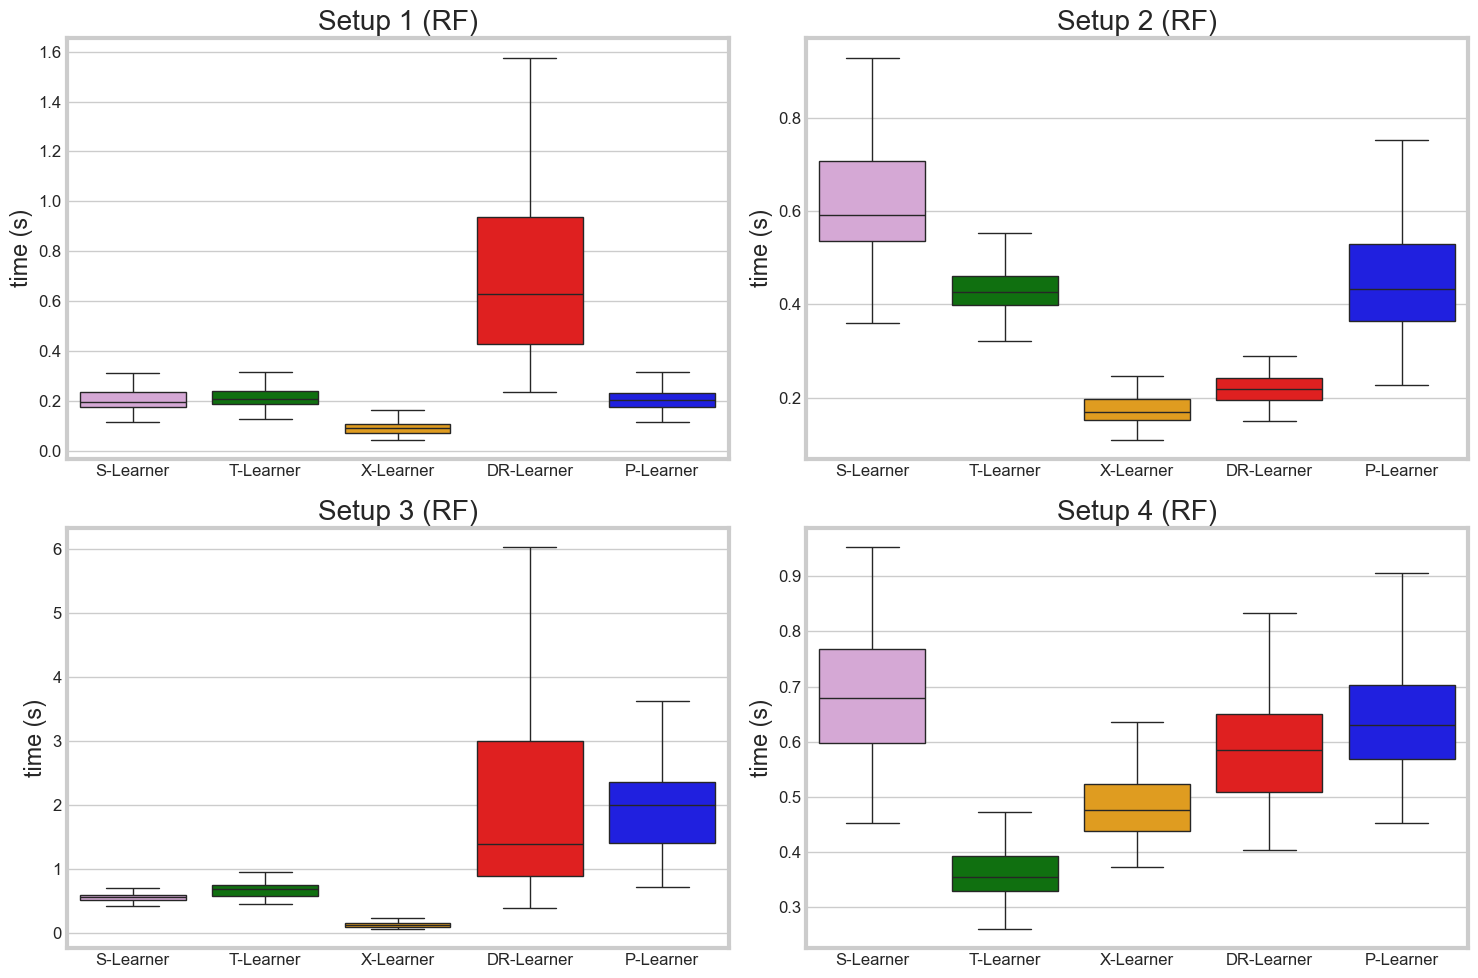

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.ravel()

for i, m in zip(range(4), m_list):
    sns.boxplot(x='learner', y='pehe', data=df_res_nn.loc[(df_res_nn['sim_mode'] == m) & (df_res_nn['sigma'] == 1) & 
                                                          (df_res_nn['learner'] != 'RT-Learner')], linewidth=1, showfliers=False, 
                                                          ax=axs[i], palette=palette)
    axs[i].title.set_text(data_generation_descs[m] + r' (RF)')
    axs[i].set_ylabel('time (s)')
    axs[i].set_xlabel('')
    axs[i].tick_params(labelsize=12)
plt.tight_layout()


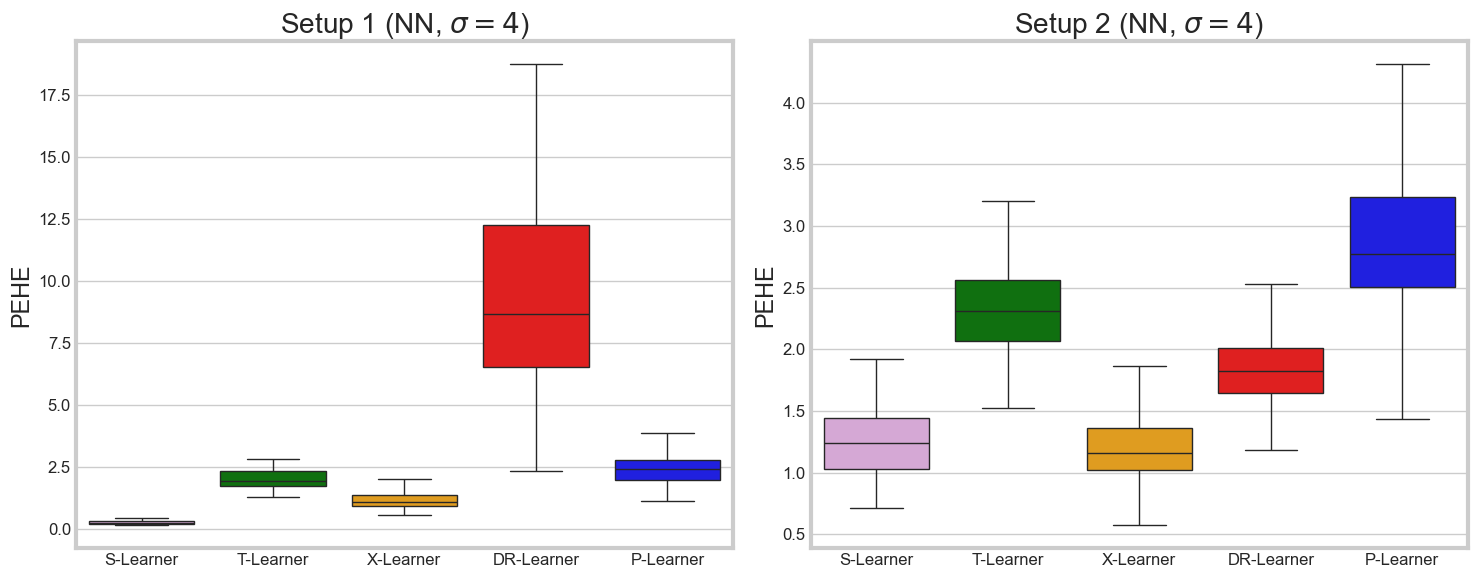

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs = axs.ravel()

for i, m in zip(range(2), m_list):
    sns.boxplot(x='learner', y='pehe', data=df_res_nn.loc[(df_res_nn['sim_mode'] == m) & (df_res_nn['sigma'] == 4) & 
                                                          (df_res_nn['learner'] != 'RT-Learner')], linewidth=1, showfliers=False, 
                                                          ax=axs[i], palette=palette)
    axs[i].title.set_text(data_generation_descs[m] + r' (NN, $\sigma=4$)')
    axs[i].set_ylabel('PEHE')
    axs[i].set_xlabel('')
    axs[i].tick_params(labelsize=12)
plt.tight_layout()
